In [1]:

import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import poisson,skellam
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [2]:

# LOAD DATA
norwegian_results = pd.read_csv('NOR.csv')
norwegian_results = norwegian_results.loc[norwegian_results['Season'] == 2012]
norwegian_results = norwegian_results[['Home','Away','HG','AG']]
norwegian_results = norwegian_results.rename(columns={'HG': 'HomeGoals', 'AG': 'AwayGoals'})
norwegian_results = norwegian_results[:-2]

print(norwegian_results.head())


       Home          Away  HomeGoals  AwayGoals
0     Molde  Stromsgodset          2          1
1  Honefoss    Lillestrom          0          0
2       Odd       Sogndal          0          4
3   Stabaek      Aalesund          0          0
4    Tromso   Fredrikstad          1          0


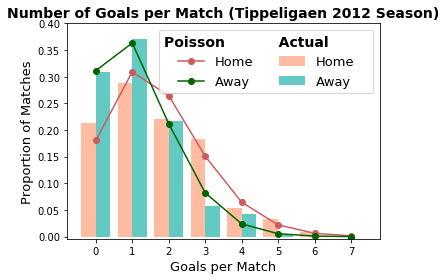

In [7]:

# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, norwegian_results.mean()[j]) for i in range(8)] for j in range(2)])
# plot histogram of actual goals
plt.hist(norwegian_results[['HomeGoals', 'AwayGoals']].values, range(9),
         alpha=0.7, label=['Home', 'Away'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (Tippeligaen 2012 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()



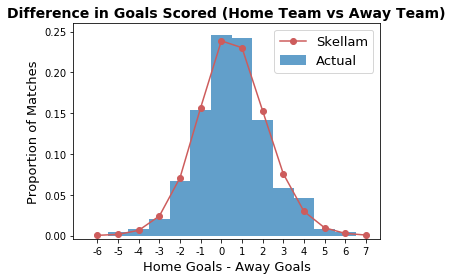

In [8]:

# Proportion of Home goals vs Away goals (Note that we consider the number of goals scored by each team to be 
# independent events (i.e. P(A n B) = P(A) P(B)). The difference of two Poisson distribution is actually 
# called a Skellam distribution.)

skellam_pred = [skellam.pmf(i,  norwegian_results.mean()[0],  norwegian_results.mean()[1]) for i in range(-6,8)]
plt.hist(norwegian_results[['HomeGoals']].values - norwegian_results[['AwayGoals']].values, range(-6,8),
         alpha=0.7, label='Actual',density=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()



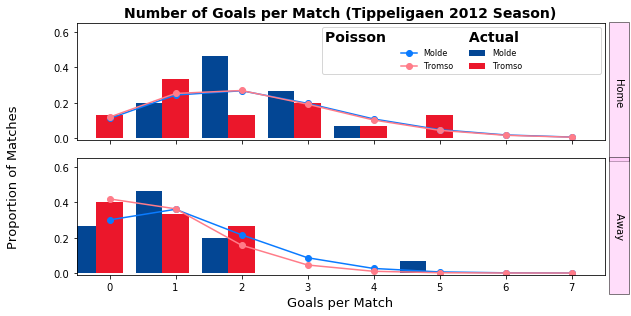

In [9]:

fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(8,4.5))

mold_home = norwegian_results[norwegian_results['Home']=='Molde'][['HomeGoals']].apply(pd.value_counts,normalize=True)
mold_home_pois = [poisson.pmf(i,np.sum(np.multiply(mold_home.values.T,mold_home.index.T),axis=1)[0]) for i in range(8)]
trom_home = norwegian_results[norwegian_results['Home']=='Tromso'][['HomeGoals']].apply(pd.value_counts,normalize=True)
trom_home_pois = [poisson.pmf(i,np.sum(np.multiply(trom_home.values.T,trom_home.index.T),axis=1)[0]) for i in range(8)]

mold_away = norwegian_results[norwegian_results['Away']=='Molde'][['AwayGoals']].apply(pd.value_counts,normalize=True)
mold_away_pois = [poisson.pmf(i,np.sum(np.multiply(mold_away.values.T,mold_away.index.T),axis=1)[0]) for i in range(8)]
trom_away = norwegian_results[norwegian_results['Away']=='Tromso'][['AwayGoals']].apply(pd.value_counts,normalize=True)
trom_away_pois = [poisson.pmf(i,np.sum(np.multiply(trom_away.values.T,trom_away.index.T),axis=1)[0]) for i in range(8)]


ax1.bar(mold_home.index-0.4,mold_home.values.T[0],width=0.4,color="#034694",label="Molde")
ax1.bar(trom_home.index,trom_home.values.T[0],width=0.4,color="#EB172B",label="Tromso")
pois1, = ax1.plot([i for i in range(8)], mold_home_pois,
                  linestyle='-', marker='o',label="Molde", color = "#0a7bff")
pois1, = ax1.plot([i for i in range(8)], trom_home_pois,
                  linestyle='-', marker='o',label="Tromso", color = "#ff7c89")
leg=ax1.legend(loc='upper right', fontsize=8, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':14, 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])
ax1.set_xticklabels([])
# mimicing the facet plots in ggplot2 with a bit of a hack
ax1.text(7.65, 0.585, '                Home                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})
ax2.text(7.65, 0.585, '                Away                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})

ax2.bar(mold_away.index-0.4,mold_away.values.T[0],width=0.4,color="#034694",label="Molde")
ax2.bar(trom_away.index,trom_away.values.T[0],width=0.4,color="#EB172B",label="Tromso")
pois1, = ax2.plot([i for i in range(8)], mold_away_pois,
                  linestyle='-', marker='o',label="Molde", color = "#0a7bff")
pois1, = ax2.plot([i for i in range(8)], trom_away_pois,
                  linestyle='-', marker='o',label="Tromso", color = "#ff7c89")
ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])
ax1.set_title("Number of Goals per Match (Tippeligaen 2012 Season)",size=14,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=13)
ax2.text(-1.55, 0.9, 'Proportion of Matches', rotation=90, size=13)
plt.tight_layout()
plt.show()



In [10]:


# A generalised Poisson regression
goal_model_data = pd.concat([norwegian_results[['Home','Away','HomeGoals']].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','HomeGoals':'goals'}),
           norwegian_results[['Away','Home','AwayGoals']].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
print(poisson_model.summary())




                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  480
Model:                            GLM   Df Residuals:                      448
Model Family:                 Poisson   Df Model:                           31
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -696.13
Date:                Thu, 23 Jul 2020   Deviance:                       514.54
Time:                        12:27:09   Pearson chi2:                     446.
No. Iterations:                     5   Covariance Type:             nonrobust
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0176      0.231      0.076      0.939      -0.434       0.470
team[T.Bra

In [39]:


### This is a model trained also on the game we trying to predict here ###


# SIMULATED MATCH RETURNS AN MAX_GOALS+1 x MAX_GOALS+1 ARRAY
# WHERE THE SUM OF THE DIAGONAL IS P(DRAW)
# THE SUM OF THE LOWER TRIANGLE IS P(HOME), sum(MATRIX column1) = P(1 home goal)
# AND THE SUM OF THE TOP TRIANGLE IS P(AWAY)

def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))


mold_trom = simulate_match(poisson_model, "Molde", "Tromso", max_goals=10)

# Molde win
print('Probability of home win : ', np.sum(np.tril(mold_trom, -1)))
# Draw
print('Probability of draw : ', np.sum(np.diag(mold_trom)))
# Tromso win
print('Probability of away win : ', np.sum(np.triu(mold_trom, 1)))

print('True game result: \n', norwegian_results[(norwegian_results['Home']=='Molde') & (norwegian_results['Away']=='Tromso')])



Probability of home win :  0.5141954377356244
Probability of draw :  0.2643907578054903
Probability of away win :  0.2214133320076855
True game result: 
      Home    Away  HomeGoals  AwayGoals
86  Molde  Tromso          3          2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, q, home, opponent[T.Viking], opponent[T.Valerenga], opponent[T.Tromso], opponent[T.Stromsgodset], opponent[T.Stabaek], opponent[T.Sogndal], opponent[T.Sandnes], opponent[T.Rosenborg], opponent[T.Odd], opponent[T.Molde], opponent[T.Lillestrom], opponent[T.Honefoss], opponent[T.Haugesund], opponent[T.Fredrikstad], opponent[T.Brann], team[T.Viking], team[T.Valerenga], team[T.Tromso], team[T.Stromsgodset], team[T.Stabaek], team[T.Sogndal], team[T.Sandnes], team[T.Rosenborg], team[T.Odd], team[T.Molde], team[T.Lillestrom], team[T.Honefoss], team[T.Haugesund], team[T.Fredrikstad], team[T.Brann], Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:58<00:00, 68.08it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some p

                              mean         sd  mc_error   hpd_2.5  hpd_97.5  \
Intercept                 0.612628   0.321757  0.012563  0.028967  1.309754   
team[T.Brann]             0.648697   0.291869  0.008048  0.114005  1.255448   
team[T.Fredrikstad]       0.166538   0.300595  0.008202 -0.434799  0.747924   
team[T.Haugesund]         0.321958   0.300650  0.008642 -0.229129  0.931866   
team[T.Honefoss]         -0.287827   0.321565  0.008323 -0.900298  0.345300   
team[T.Lillestrom]        0.406059   0.308560  0.009030 -0.199947  1.008013   
team[T.Molde]             0.299604   0.305580  0.008507 -0.249724  0.928943   
team[T.Odd]               0.114147   0.307757  0.008570 -0.512513  0.673151   
team[T.Rosenborg]         0.603681   0.303855  0.008597  0.032558  1.221205   
team[T.Sandnes]           0.346702   0.306676  0.008304 -0.251618  0.942106   
team[T.Sogndal]          -0.344346   0.325307  0.008472 -1.001592  0.258281   
team[T.Stabaek]          -0.359492   0.328012  0.008

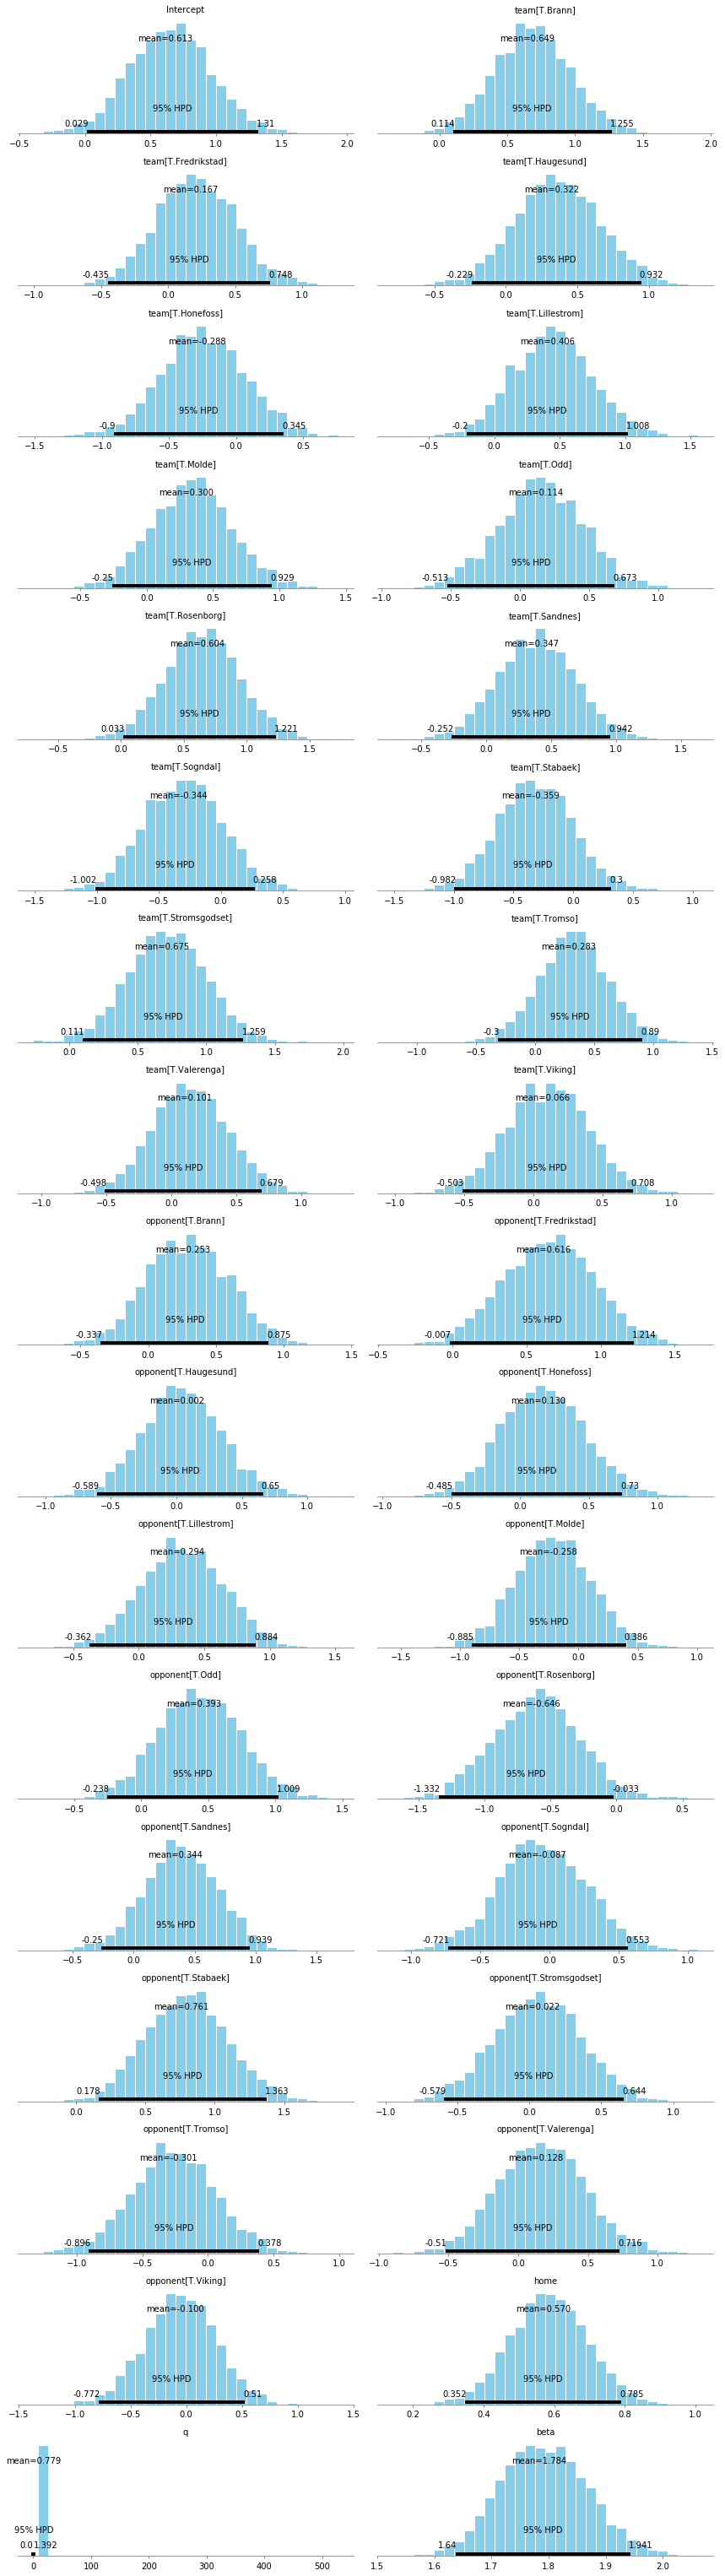

In [38]:


# A bayesian approach to the model with model summary, no prediction made here. And that is all for now!

def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log', rv.name) or re.search('_interval', rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


# PYMC3 

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula="goals ~ home + team + opponent", data=goal_model_data,
                            family=pm.glm.families.DiscreteWeibull())
                            # family=pm.glm.families.Poisson())
                            # family=pm.glm.families.NegativeBinomial())

    trace = pm.sample(2000, tune=2000, cores=1)

varnames = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
# print(plot_traces(trace, varnames=varnames))
# pm.traceplot(trace, varnames)
# print(np.exp(pm.summary(trace, varnames=varnames)[['mean','hpd_2.5','hpd_97.5']]))
print(pm.summary(trace, varnames=varnames))
pm.plot_posterior(trace)
plt.show()


